In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Set a style for more paper-like aesthetics (optional, can be commented out)
# plt.style.use('seaborn-v0_8-paper') # or 'seaborn-v0_8-whitegrid'
# Or use rcParams for finer control
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 9,
    'figure.titlesize': 16
})


def compute_effective_rank(matrix):
    """
    Compute the effective rank of a matrix using singular values.
    Effective Rank = exp(Entropy(normalized_singular_values))
    """
    if isinstance(matrix, torch.Tensor):
        matrix = matrix.detach().cpu().numpy()
    
    s_unnormalized = np.linalg.svd(matrix, compute_uv=False) # Get unnormalized singular values
    sum_s = np.sum(s_unnormalized)
    if sum_s < 1e-12:
        return 0.0

    s_norm = s_unnormalized / sum_s # Normalize for entropy calculation
    s_norm = s_norm[s_norm > 1e-15]
    
    if len(s_norm) == 0:
        return 0.0

    entropy = -np.sum(s_norm * np.log(s_norm))
    effective_rank_val = np.exp(entropy)
    return effective_rank_val

def get_matrix_analysis(matrix, name="Matrix", tol_abs=None):
    """Computes SVD threshold rank (from unnormalized svals), 
       normalized singular values (eigenvalues) for plotting, and effective rank."""
    
    svals_unnormalized = torch.linalg.svdvals(matrix) # Original eigenvalues
    
    # Calculate SVD threshold rank based on unnormalized singular values
    if tol_abs is None: # Use relative tolerance if absolute is not given
        tol_rank_calc = svals_unnormalized.max() * max(matrix.shape) * torch.finfo(svals_unnormalized.dtype).eps
    else:
        tol_rank_calc = tol_abs # Use a fixed absolute tolerance if provided
    rank_svd_threshold = torch.sum(svals_unnormalized > tol_rank_calc).item()

    # Normalize svals for plotting and for display in print if desired
    sum_svals_unnormalized = torch.sum(svals_unnormalized)
    if sum_svals_unnormalized < 1e-12: # Avoid division by zero if matrix is essentially zero
        svals_normalized_for_plot = torch.zeros_like(svals_unnormalized)
    else:
        svals_normalized_for_plot = svals_unnormalized / sum_svals_unnormalized
    
    # Effective rank is calculated based on the original matrix's singular value distribution
    eff_rank = compute_effective_rank(matrix.clone()) 
    
    print(f"--- Analysis for {name} ---")
    print(f"Top Unnormalized Eigenvalues (Sorted):")
    if len(svals_unnormalized) > 8:
        print(f"  Top 5: {svals_unnormalized[:5].detach().cpu().numpy()}")
        print(f"  Bottom 3: {svals_unnormalized[-3:].detach().cpu().numpy()}")
    else:
        print(f"  All: {svals_unnormalized.detach().cpu().numpy()}")
    print(f"SVD Threshold Rank (Tol={tol_rank_calc:.2e}): {rank_svd_threshold}")
    print(f"Effective Rank (based on original svals): {eff_rank:.4f}")
    print(f"Sum of unnormalized eigenvalues: {sum_svals_unnormalized:.4f}")
    print("-" * 50)
        
    return rank_svd_threshold, svals_normalized_for_plot, eff_rank, svals_unnormalized

def main():
    # --- Parameters ---
    d_full = 10
    k_rank = 4
    n_samples = 60000 # Increased samples for better empirical estimates
    abs_tol_svd_rank = 1e-7 # Absolute tolerance for SVD rank counting

    if not (2 <= k_rank < d_full):
        raise ValueError(f"k_rank must be between 2 and d_full-1. Got k_rank={k_rank}, d_full={d_full}.")

    print(f"Settings: d_full = {d_full}, k_rank = {k_rank}, n_samples = {n_samples}\n")

    # --- 1. Generate Base Rank-Deficient Features ---
    L = torch.randn(n_samples, k_rank)
    A_coeffs = torch.randn(d_full, k_rank)
    A_row_norms_for_corr_structure = torch.linalg.norm(A_coeffs, dim=1, keepdim=True)
    A_normalized_for_corr_structure = A_coeffs / (A_row_norms_for_corr_structure + 1e-9)
    z_base_correlated = L @ A_normalized_for_corr_structure.T

    # --- 2. Create Non-Standard Gaussian Features (`z_raw`) ---
    custom_scales = torch.rand(d_full) * 2 # Scales approx in [0.5, 2.0]
    z_scaled = z_base_correlated * custom_scales
    custom_means = torch.randn(d_full) * 0.0 # Means, e.g., in [-3, 3]
    z_raw = z_scaled + custom_means # Renamed from z_non_standard for legend clarity
    print("Generated non-standard Gaussian features (z_raw).\n")

    activation_fn = torch.tanh
    print(f"Using activation function: {activation_fn.__name__ if hasattr(activation_fn, '__name__') else activation_fn.__class__.__name__}\n")

    # --- Path 1: Direct Activation on Non-Standard Features (`z_raw`) ---
    print("=== Path 1: Activation on Raw (Non-Standard) Features ===")
    cov_z_raw = torch.cov(z_raw.T)
    rank_z_raw, svals_norm_z_raw, eff_rank_z_raw, _ = get_matrix_analysis(cov_z_raw, "Cov(z_raw)", tol_abs=abs_tol_svd_rank)

    h_from_raw = activation_fn(z_raw)
    cov_h_from_raw = torch.cov(h_from_raw.T)
    rank_h_raw, svals_norm_h_raw, eff_rank_h_raw, _ = get_matrix_analysis(cov_h_from_raw, "Cov(f(z_raw))", tol_abs=abs_tol_svd_rank)

    # --- Path 2: Normalize Raw Features First, then Activate ---
    print("\n=== Path 2: Normalization then Activation (z_norm) ===")
    mean_z_raw_empirical = torch.mean(z_raw, dim=0, keepdim=True)
    std_z_raw_empirical = torch.std(z_raw, dim=0, keepdim=True)
    # Ensure std_dev is not too small before division
    z_norm = (z_raw - mean_z_raw_empirical) / (std_z_raw_empirical + 1e-7)


    cov_z_norm = torch.cov(z_norm.T)
    rank_z_norm, svals_norm_z_norm, eff_rank_z_norm, _ = get_matrix_analysis(cov_z_norm, "Cov(z_norm) (Empirical Correlation Matrix)", tol_abs=abs_tol_svd_rank)

    h_from_norm = activation_fn(z_norm)
    cov_h_from_norm = torch.cov(h_from_norm.T)
    rank_h_norm, svals_norm_h_norm, eff_rank_h_norm, _ = get_matrix_analysis(cov_h_from_norm, "Cov(f(z_norm))", tol_abs=abs_tol_svd_rank)

    # --- Validation Summaries ---
    print("\n--- Validation Summary for Path 1 (Raw Features) ---")
    path1_crit1_hard_rank_full = (rank_h_raw == d_full)
    path1_crit2_eff_rank_increased = (eff_rank_h_raw > eff_rank_z_raw)
    print(f"Cov(z_raw): SVD Rank = {rank_z_raw}, Effective Rank = {eff_rank_z_raw:.4f}")
    print(f"Cov(f(z_raw)): SVD Rank = {rank_h_raw}, Effective Rank = {eff_rank_h_raw:.4f}")
    if path1_crit1_hard_rank_full and path1_crit2_eff_rank_increased:
        print("Result for Path 1: Rank recovery observed (Hard rank full, Effective rank increased).")
    # ... (rest of summary logic as before) ...

    print("\n--- Validation Summary for Path 2 (Normalized Features - Aligns with Proposition Conditions) ---")
    path2_crit1_hard_rank_full = (rank_h_norm == d_full)
    path2_crit2_eff_rank_increased = (eff_rank_h_norm > eff_rank_z_norm)
    print(f"Cov(z_norm): SVD Rank = {rank_z_norm}, Effective Rank = {eff_rank_z_norm:.4f}")
    print(f"Cov(f(z_norm)): SVD Rank = {rank_h_norm}, Effective Rank = {eff_rank_h_norm:.4f}")
    if path2_crit1_hard_rank_full and path2_crit2_eff_rank_increased:
        print("Result for Path 2: Proposition validated (Hard rank full, Effective rank increased).")
    # ... (rest of summary logic as before) ...


    # --- Combined Eigenvalue Visualization ---
    fig, ax = plt.subplots(1, 1, figsize=(10, 7)) # Single plot
    
    indices = np.arange(1, d_full + 1)

    # Path 1: Raw (Non-Standard) Features
    # Using slightly more distinct colors and ensuring markers are visible
    color_z_raw = '#377eb8' # Blue
    color_h_raw = '#4daf4a' # Green
    ax.plot(indices, svals_norm_z_raw.detach().cpu().numpy(), marker='o', linestyle='--', markersize=7, fillstyle='none',
             label=fr'$\Sigma(z_{{raw}})$ [R:{rank_z_raw}, ER:{eff_rank_z_raw:.1f}]', 
             color=color_z_raw, alpha=0.9)
    ax.plot(indices, svals_norm_h_raw.detach().cpu().numpy(), marker='o', linestyle='-', markersize=7,
             label=fr'$\Sigma(f(z_{{raw}}))$ [R:{rank_h_raw}, ER:{eff_rank_h_raw:.1f}]', 
             color=color_h_raw)

    # Path 2: Normalized Features
    color_z_norm = '#ff7f00' # Orange
    color_h_norm = '#e41a1c' # Red
    ax.plot(indices, svals_norm_z_norm.detach().cpu().numpy(), marker='s', linestyle='--', markersize=7, fillstyle='none',
             label=fr'$\Sigma(z_{{norm}})$ [R:{rank_z_norm}, ER:{eff_rank_z_norm:.1f}]', 
             color=color_z_norm, alpha=0.9)
    ax.plot(indices, svals_norm_h_norm.detach().cpu().numpy(), marker='s', linestyle='-', markersize=7,
             label=fr'$\Sigma(f(z_{{norm}}))$ [R:{rank_h_norm}, ER:{eff_rank_h_norm:.1f}]', 
             color=color_h_norm)
    
    ax.set_title(f'Normalized Eigenvalue Spectra of Covariance Matrices ($d={d_full}, k={k_rank}$)')
    ax.set_xlabel("Eigenvalue Index (Sorted Descending)")
    ax.set_ylabel("Normalized Eigenvalue (Log Scale)")
    ax.set_yscale('log')
    
    if d_full <= 20:
        ax.set_xticks(indices)
    else:
        ax.set_xticks(np.linspace(1, d_full, min(d_full, 10), dtype=int))
        
    # Add a vertical line for k_rank
    line_k_rank = ax.axvline(x=k_rank + 0.5, color='dimgray', linestyle=':', linewidth=1.5, label=f'Initial Rank $k={k_rank}$')
    
    # Create legend
    handles, labels = ax.get_legend_handles_labels()
    # Ensure k_rank line is included if desired, or handle its label separately.
    # For now, it will be part of the auto-generated legend.
    ax.legend(handles=handles, labels=labels, loc='center left', bbox_to_anchor=(1.01, 0.5), 
              fontsize='small', title="Legend [R: SVD Rank, ER: Eff. Rank]")
    
    ax.grid(True, which="both", ls="--", alpha=0.5)

    fig.subplots_adjust(right=0.75) # Make space for legend outside
    plt.show()

if __name__ == "__main__":
    main()

Experiment Settings: d_full=10, k_rank=3, n_samples=70000
Activation: Tanh, Scales: [0.05, 0.5, 1.5, 5.0], Normalized Scenario: True

--- Analysis for Cov(z_base) - Input Reference ---
  Top 5 Unnormalized Eigenvalues: [4.2270637e+00 3.6424615e+00 2.0946727e+00 1.4610240e-05 1.3245243e-05]
  SVD Threshold Rank (Tol=5.04e-06): 7
  Effective Rank: 2.8851
  Sum of Eigenvalues: 9.9642
--------------------------------------------------

=== Scenario: ScaledInput_s0.05 ===
--- Analysis for Cov(z_input, s=0.05) ---
  Top 5 Unnormalized Eigenvalues: [1.0567687e-02 9.1061443e-03 5.2366899e-03 4.6561215e-08 3.6929492e-08]
  SVD Threshold Rank (Tol=1.00e-07): 3
  Effective Rank: 2.8852
  Sum of Eigenvalues: 0.0249
--------------------------------------------------
--- Analysis for Cov(Tanh(z_input)) for ScaledInput_s0.05 ---
  Top 5 Unnormalized Eigenvalues: [1.0515208e-02 9.0606818e-03 5.2107805e-03 4.7619164e-08 3.8506897e-08]
  SVD Threshold Rank (Tol=1.00e-07): 3
  Effective Rank: 2.8852
  Su

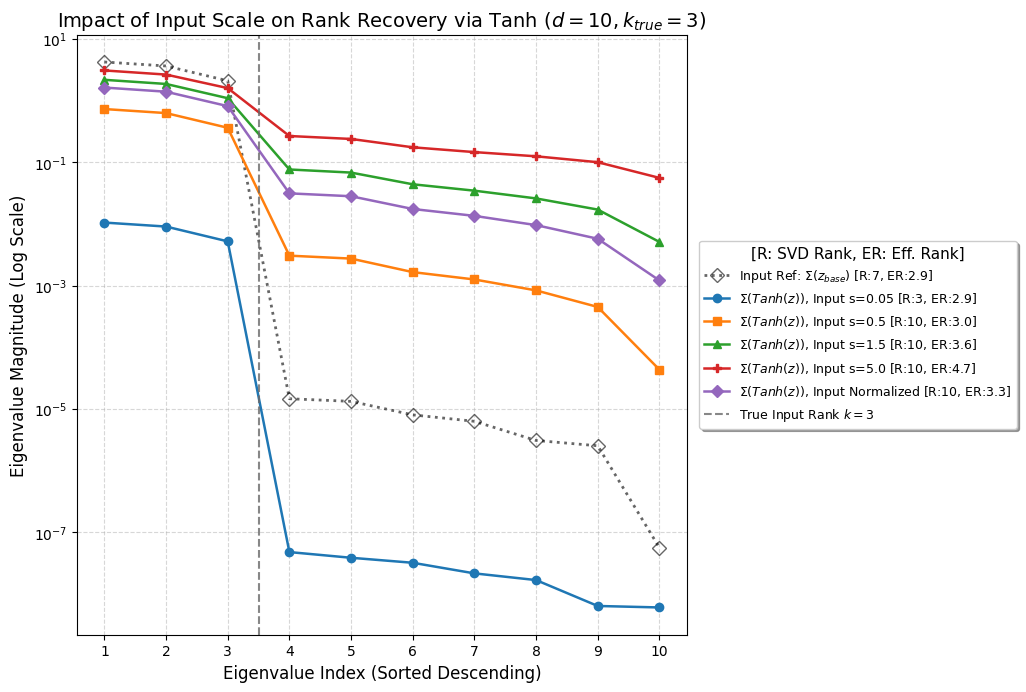

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Optional: Style for paper-like aesthetics
plt.rcParams.update({
    'font.size': 11,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 9,
    'figure.titlesize': 16,
    'lines.linewidth': 1.8,
    'lines.markersize': 6
})

def compute_effective_rank(matrix):
    """ Computes effective rank from the original matrix (handles normalization internally). """
    if isinstance(matrix, torch.Tensor):
        matrix = matrix.detach().cpu().numpy()
    s_unnormalized = np.linalg.svd(matrix, compute_uv=False)
    sum_s = np.sum(s_unnormalized)
    if sum_s < 1e-12: return 0.0
    s_norm_for_entropy = s_unnormalized / sum_s # Internal normalization for entropy
    s_norm_for_entropy = s_norm_for_entropy[s_norm_for_entropy > 1e-15]
    if len(s_norm_for_entropy) == 0: return 0.0
    entropy = -np.sum(s_norm_for_entropy * np.log(s_norm_for_entropy))
    return np.exp(entropy)

def get_matrix_analysis(matrix, name="Matrix", abs_tol_svd_rank=1e-7):
    """
    Computes SVD threshold rank from unnormalized eigenvalues, 
    returns unnormalized eigenvalues, and effective rank.
    """
    svals_unnormalized = torch.linalg.svdvals(matrix) # These are the actual eigenvalues
    
    # Robust tolerance for SVD rank calculation based on unnormalized eigenvalues
    # Relative tolerance component
    rel_tol = svals_unnormalized.max() * max(matrix.shape) * torch.finfo(svals_unnormalized.dtype).eps \
        if svals_unnormalized.numel() > 0 and svals_unnormalized.max() > 0 else torch.tensor(0.0) # handle empty or zero svals
    
    current_tol_rank = max(rel_tol, torch.tensor(abs_tol_svd_rank, dtype=svals_unnormalized.dtype))
    
    # Ensure current_tol_rank is a scalar tensor or float for comparison
    if not isinstance(current_tol_rank, torch.Tensor):
         current_tol_rank = torch.tensor(current_tol_rank)
    if current_tol_rank.ndim > 0: # Ensure it's a scalar
        current_tol_rank = current_tol_rank.item()


    rank_svd_threshold = torch.sum(svals_unnormalized > current_tol_rank).item()
    
    eff_rank = compute_effective_rank(matrix.clone()) # Effective rank uses original matrix
    
    print(f"--- Analysis for {name} ---")
    print(f"  Top 5 Unnormalized Eigenvalues: {svals_unnormalized[:min(5, len(svals_unnormalized))].detach().cpu().numpy()}")
    print(f"  SVD Threshold Rank (Tol={current_tol_rank:.2e}): {rank_svd_threshold}")
    print(f"  Effective Rank: {eff_rank:.4f}")
    print(f"  Sum of Eigenvalues (Trace): {torch.sum(svals_unnormalized):.4f}")
    print("-" * 50)
    # Return UNNORMALIZED eigenvalues for plotting actual magnitudes
    return rank_svd_threshold, svals_unnormalized, eff_rank

def get_activation_fn_and_name(activation_name_str):
    # (Implementation as in the previous response)
    activation_name_str = activation_name_str.lower()
    if activation_name_str == "tanh":
        return torch.tanh, "Tanh"
    elif activation_name_str == "relu":
        return torch.relu, "ReLU"
    elif activation_name_str == "sigmoid":
        return torch.sigmoid, "Sigmoid"
    elif activation_name_str == "gelu":
        return torch.nn.GELU(), "GELU"
    else:
        raise ValueError(f"Unsupported activation function: {activation_name_str}")

def run_experiment(
    d_full=10, 
    k_rank=3, 
    n_samples=60000, 
    abs_tol_svd_rank_config=1e-6, # Renamed to avoid conflict
    activation_name_str="tanh",
    scale_factors_list=[0.05, 1.5, 10.0],
    include_normalized_scenario_flag=True
):
    if not (2 <= k_rank < d_full):
        raise ValueError(f"k_rank must be between 2 and d_full-1. Got k_rank={k_rank}, d_full={d_full}.")

    activation_fn, activation_display_name = get_activation_fn_and_name(activation_name_str)

    print(f"Experiment Settings: d_full={d_full}, k_rank={k_rank}, n_samples={n_samples}")
    print(f"Activation: {activation_display_name}, Scales: {scale_factors_list}, Normalized Scenario: {include_normalized_scenario_flag}\n")

    # --- 1. Generate Base Rank-Deficient Features (z_base) ---
    # Cov(z_base) should be a correlation-like matrix (rank k_rank, diag ~1)
    L = torch.randn(n_samples, k_rank)
    A_coeffs = torch.randn(d_full, k_rank)
    A_row_norms = torch.linalg.norm(A_coeffs, dim=1, keepdim=True)
    A_normalized = A_coeffs / (A_row_norms + 1e-9)
    z_base = L @ A_normalized.T # Mean is ~0, Covariance has rank k_rank, diag elements are 1.
    
    # Analyze Cov(z_base)
    cov_z_base_matrix = torch.cov(z_base.T)
    rank_z_base, svals_z_base, eff_rank_z_base = get_matrix_analysis(
        cov_z_base_matrix, "Cov(z_base) - Input Reference", abs_tol_svd_rank=abs_tol_svd_rank_config
    )
    # This assertion is critical for the experiment's baseline
    if rank_z_base != k_rank:
         print(f"CRITICAL WARNING: Base input Cov(z_base) SVD rank is {rank_z_base}, expected {k_rank}. "
               f"Results for other scenarios might be misleading. "
               f"Consider adjusting abs_tol_svd_rank_config ('{abs_tol_svd_rank_config}') or increasing n_samples.")

    results_list = []

    # --- Scaled Input Scenarios ---
    for scale_factor in scale_factors_list:
        scenario_name = f"ScaledInput_s{scale_factor}"
        print(f"\n=== Scenario: {scenario_name} ===")
        
        z_input_to_activation = z_base * scale_factor # z_base has mean ~0. Scaling preserves this.
        input_cov_name = f"Cov(z_input, s={scale_factor})"
        
        cov_z_scenario_input = torch.cov(z_input_to_activation.T)
        rank_z_scenario, svals_z_scenario, eff_rank_z_scenario = get_matrix_analysis(
            cov_z_scenario_input, input_cov_name, abs_tol_svd_rank=abs_tol_svd_rank_config
        )
        if rank_z_scenario != k_rank: # Rank of scaled input should also be k_rank
            print(f"WARNING: Pre-activation SVD rank for {scenario_name} is {rank_z_scenario}, expected {k_rank}")

        h_output = activation_fn(z_input_to_activation)
        cov_h_output = torch.cov(h_output.T)
        output_cov_name = f"Cov({activation_display_name}(z_input)) for {scenario_name}"
        rank_h_output, svals_h_output, eff_rank_h_output = get_matrix_analysis(
            cov_h_output, output_cov_name, abs_tol_svd_rank=abs_tol_svd_rank_config
        )
        results_list.append({
            "name": scenario_name, "svals_z": svals_z_scenario, "rank_z": rank_z_scenario, "eff_rank_z": eff_rank_z_scenario,
            "svals_h": svals_h_output, "rank_h": rank_h_output, "eff_rank_h": eff_rank_h_output,
            "plot_label_suffix": f"Input s={scale_factor}"
        })

    # --- Normalized Input Scenario ---
    if include_normalized_scenario_flag:
        scenario_name = "NormalizedInput"
        print(f"\n=== Scenario: {scenario_name} ===")
        
        # Create an intermediate z with varied scales and means *before* normalization
        varied_scales_for_norm_path = torch.rand(d_full) * 1.8 + 0.2 # Scales e.g. in [0.2, 2.0]
        z_intermediate_raw = z_base * varied_scales_for_norm_path # Still rank k_rank, zero mean
        # Optionally add mean to make it more "raw" before normalization
        # z_intermediate_raw += torch.randn(d_full) * 0.5 
        
        mean_emp = torch.mean(z_intermediate_raw, dim=0, keepdim=True)
        std_emp = torch.std(z_intermediate_raw, dim=0, keepdim=True)
        z_input_to_activation = (z_intermediate_raw - mean_emp) / (std_emp + 1e-7) # Now normalized
        input_cov_name = "Cov(z_normalized_input) (Effectively Correlation Matrix)"

        cov_z_scenario_input = torch.cov(z_input_to_activation.T)
        rank_z_scenario, svals_z_scenario, eff_rank_z_scenario = get_matrix_analysis(
            cov_z_scenario_input, input_cov_name, abs_tol_svd_rank=abs_tol_svd_rank_config
        )
        if rank_z_scenario != k_rank:
             print(f"WARNING: Pre-activation SVD rank for {scenario_name} is {rank_z_scenario}, expected {k_rank}")
            
        h_output = activation_fn(z_input_to_activation)
        cov_h_output = torch.cov(h_output.T)
        output_cov_name = f"Cov({activation_display_name}(z_input)) for {scenario_name}"
        rank_h_output, svals_h_output, eff_rank_h_output = get_matrix_analysis(
            cov_h_output, output_cov_name, abs_tol_svd_rank=abs_tol_svd_rank_config
        )
        results_list.append({
            "name": scenario_name, "svals_z": svals_z_scenario, "rank_z": rank_z_scenario, "eff_rank_z": eff_rank_z_scenario,
            "svals_h": svals_h_output, "rank_h": rank_h_output, "eff_rank_h": eff_rank_h_output,
            "plot_label_suffix": "Input Normalized"
        })
    
    # ... (Print Validation Summaries as before) ...
    for res in results_list:
        print(f"\n--- Validation Summary for Scenario: {res['name']} ({res['plot_label_suffix']}) ---")
        crit1_hard_rank_full = (res['rank_h'] == d_full)
        crit2_eff_rank_increased = (res['eff_rank_h'] > res['eff_rank_z'])
        print(f"  Pre-activation: Cov(z_input): SVD Rank = {res['rank_z']}, Effective Rank = {res['eff_rank_z']:.4f}")
        print(f"  Post-activation: Cov({activation_display_name}(z_input)): SVD Rank = {res['rank_h']}, Effective Rank = {res['eff_rank_h']:.4f}")
        if crit1_hard_rank_full and crit2_eff_rank_increased:
            print(f"  Result: Rank recovery observed (Hard rank full, Effective rank increased).")
        else:
            print(f"  Result: Full rank recovery criteria NOT met.")
            if not crit1_hard_rank_full: print(f"    - Hard rank for output is {res['rank_h']}, expected {d_full}.")
            if not crit2_eff_rank_increased: print(f"    - Output Eff.Rank ({res['eff_rank_h']:.4f}) not > Input Eff.Rank ({res['eff_rank_z']:.4f}).")


    # --- Combined Eigenvalue Visualization ---
    fig, ax = plt.subplots(1, 1, figsize=(11, 7.5))
    indices = np.arange(1, d_full + 1)

    # Plot reference input (Cov(z_base)) - UNNORMALIZED eigenvalues
    ax.plot(indices, svals_z_base.detach().cpu().numpy(), marker='D', linestyle=':', markersize=6, fillstyle='none',
            label=fr'Input Ref: $\Sigma(z_{{base}})$ [R:{rank_z_base}, ER:{eff_rank_z_base:.1f}]',
            color='black', alpha=0.7, linewidth=1.5)

    plot_styles = [
        {'color': '#1f77b4', 'marker': 'o'},  {'color': '#ff7f0e', 'marker': 's'},
        {'color': '#2ca02c', 'marker': '^'},  {'color': '#d62728', 'marker': 'P'},
        {'color': '#9467bd', 'marker': 'X'},  {'color': '#8c564b', 'marker': '*'}
    ]

    for i, res in enumerate(results_list):
        style = plot_styles[i % len(plot_styles)]
        label_detail = res['plot_label_suffix']
        # Plot UNNORMALIZED eigenvalues of Cov(h) for each scenario
        ax.plot(indices, res["svals_h"].detach().cpu().numpy(), marker=style['marker'], linestyle='-',
                 label=fr'$\Sigma({activation_display_name}(z))$, {label_detail} [R:{res["rank_h"]}, ER:{res["eff_rank_h"]:.1f}]',
                 color=style['color'])
    
    ax.set_title(f'Impact of Input Scale to {activation_display_name} on Output Covariance Eigenvalues ($d={d_full}, k_{{true}}={k_rank}$)')
    ax.set_xlabel("Eigenvalue Index (Sorted Descending)")
    ax.set_ylabel("Eigenvalue Magnitude (Log Scale)")
    ax.set_yscale('log')
    
    if d_full <= 20: ax.set_xticks(indices)
    else: ax.set_xticks(np.linspace(1, d_full, min(d_full, 10), dtype=int))
        
    ax.axvline(x=k_rank + 0.5, color='dimgray', linestyle='--', linewidth=1.5, alpha=0.8, label=f'True Input Rank $k={k_rank}$')
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=labels, loc='center left', bbox_to_anchor=(1.01, 0.5), 
              title="Output Covariance Spectra\n[R:SVD Rank, ER:Eff.Rank]", frameon=True)
    
    ax.grid(True, which="both", ls="--", alpha=0.5)
    fig.subplots_adjust(right=0.65, bottom=0.12, top=0.90, left=0.1) # Adjust for legend and titles
    plt.show()

if __name__ == "__main__":
    activation_to_test = "tanh"
    scales_to_test = [0.05, 0.5, 1.5, 5.0, 10.0] 
    test_normalized_input = True

    run_experiment(
        activation_name_str=activation_to_test,
        scale_factors_list=scales_to_test,
        include_normalized_scenario_flag=test_normalized_input,
        d_full=10, 
        k_rank=3,
        n_samples=70000,
        abs_tol_svd_rank_config=1e-7 # Default absolute tolerance for SVD rank
    )